In [2]:
import urllib.request

urllib.request.urlretrieve("https://zenodo.org/record/3164691/files/QG_jets_10.npz", "QG_jets.npz")

('QG_jets.npz', <http.client.HTTPMessage at 0x7f23596732b0>)

In [3]:
from IPython.display import clear_output

# Install Pytorch Geometric
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

clear_output()

# Task II: Classical Graph Neural Network (GNN) Part

Use ParticleNet’s data for Quark/Gluon jet classification. Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. Discuss the resulting performance of the 2 chosen architectures.

## Overview of the Dataset


The input file has 100k jets, exactly 50k quark and 50k gluon jets, randomly sorted. Every jet in the file contains  M  x  F  data where  M  is the maximum number of multiplicity of the jets in the file and  F  is the number of each particle's features (pt, rapidity, azimuthal angle, and Particle Data Group ID).

## Graph-Based Architectures for Jet Classification: Selection and Considerations



Here we will use Pytorch Geometric to convert our data into Graph represantation.

A Jet is encoded as a graph.

Each constitute (track) is encoded as a node of the graph, with the four-dimensional vector as its node features.  

We use the coordinates of the particles in the (eta, phi) space to calculate distance for k-NN.

In [4]:
import pandas as pd
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = np.load('/content/QG_jets.npz')
lst = df.files
print(list(df.keys()))

['X', 'y']


Here we define a custom PyTorch Geometric dataset called JetDataset. The dataset is created by iterating over the input data (x and y) and creating a Data object for each instance. The zero-particle nodes are removed, and a k-nearest neighbors (k-NN) graph is computed using the Euclidean distance metric based on the particle features. The node feature matrix is constructed from the particle features, and the target tensor is created from the jet label.

In [ ]:
import torch_geometric
from torch_geometric.data import Data, Dataset
from sklearn.neighbors import NearestNeighbors

# Load the data
x = df['X']
y = df['y']

# Define the number of node features and classes
num_node_features = 4
num_classes = 2

# Create a custom PyTorch Geometric dataset
class JetDataset(Dataset):
    def __init__(self, x, y):
        self.data_list = []
        self._indices = None
        self.transform = None
        
        for i in range(len(x)):
            # Remove zero-particle nodes
            x_graph = x[i][np.any(x[i], axis=1)]
            num_nodes = x_graph.shape[0]
            
            # Compute k-NN graph
            x_coord = x_graph[:,1:3]  # rapidity and azimuthal angle values
            if num_nodes <= 4:
                k = 2
            else:
                k = 4
            knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
            knn.fit(x_coord)
            edge_index = knn.kneighbors_graph(x_coord, mode='connectivity').tocoo()
            
            # Convert edge index to tensor
            row = torch.from_numpy(edge_index.row.astype(np.int64))
            col = torch.from_numpy(edge_index.col.astype(np.int64))
            edge_index = torch.stack([row, col], dim=0)
            
            # Create node feature matrix and target tensor
            x_node = torch.FloatTensor(x_graph)
            y_graph = torch.LongTensor([y[i]])
            
            # Create a Data object and append to data_list
            data = Data(x=x_node, edge_index=edge_index, y=y_graph)
            self.data_list.append(data)
    
    def len(self):
        return len(self.data_list)
    
    def get(self, index):
        return self.data_list[index]

# Create the PyTorch Geometric dataset
graph_dataset = JetDataset(x, y)

In [6]:
print()
print(f'Dataset: {graph_dataset}:')
print('====================')
print(f'Number of graphs: {len(graph_dataset)}')
print(f'Number of features: {graph_dataset.num_features}')
print(f'Number of classes: {graph_dataset.num_classes}')

data = graph_dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: JetDataset(100000):
Number of graphs: 100000
Number of features: 4
Number of classes: 2

Data(x=[66, 4], edge_index=[2, 264], y=[1])
Number of nodes: 66
Number of edges: 264
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


In [7]:
torch.manual_seed(12345)
dataset = graph_dataset.shuffle()

train_dataset = dataset[:80000]
test_dataset = dataset[80000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 80000
Number of test graphs: 20000


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

The model has three GCN layers, each with a hidden channel size of 64. It also has a final linear layer to output the node classifications.

In the forward method, the node feature matrix x is passed through each of the three GCN layers using the GCNConv layer class from torch_geometric.nn. The output of each layer is then passed through a ReLU activation function. The resulting node embeddings are then aggregated across all nodes in each graph in the batch using the global_mean_pool function. Finally, the aggregated node embeddings are passed through a final dropout layer and the linear output layer.

In [9]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [17]:
import matplotlib.pyplot as plt

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define lists to store accuracy and loss values during training
train_acc_list = []
test_acc_list = []

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
      data.to(device)
      out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
      data.to(device)
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1) 
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 25):
    train()
    train_acc = test(train_loader)
    train_acc_list.append(train_acc)
    test_acc = test(test_loader)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.7579, Test Acc: 0.7530
Epoch: 002, Train Acc: 0.7667, Test Acc: 0.7651
Epoch: 003, Train Acc: 0.7670, Test Acc: 0.7643
Epoch: 004, Train Acc: 0.7686, Test Acc: 0.7629
Epoch: 005, Train Acc: 0.7657, Test Acc: 0.7616
Epoch: 006, Train Acc: 0.7663, Test Acc: 0.7635
Epoch: 007, Train Acc: 0.7685, Test Acc: 0.7650
Epoch: 008, Train Acc: 0.7542, Test Acc: 0.7499
Epoch: 009, Train Acc: 0.7659, Test Acc: 0.7613
Epoch: 010, Train Acc: 0.7662, Test Acc: 0.7616
Epoch: 011, Train Acc: 0.7656, Test Acc: 0.7634
Epoch: 012, Train Acc: 0.7568, Test Acc: 0.7530
Epoch: 013, Train Acc: 0.7702, Test Acc: 0.7676
Epoch: 014, Train Acc: 0.7694, Test Acc: 0.7667
Epoch: 015, Train Acc: 0.7692, Test Acc: 0.7646
Epoch: 016, Train Acc: 0.7670, Test Acc: 0.7639
Epoch: 017, Train Acc: 0.7661, Test Acc: 0.7606
Epoch: 018, Train Acc: 0.7701, Test Acc: 0.7669
Epoch: 019, Train Acc: 0.7710, Test Acc: 0.7677
Epoch: 020, Train Acc: 0.7621, Test Acc: 0.7587
Epoch: 021, Train Acc: 0.7616, Test Acc:

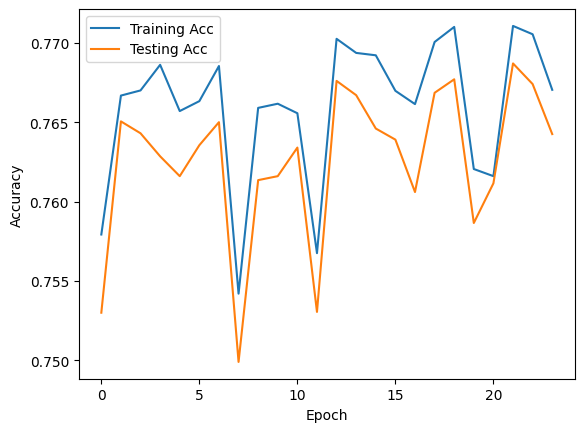

In [18]:
# Plot training and testing accuracy vs epochs
plt.plot(train_acc_list, label='Training Acc')
plt.plot(test_acc_list, label='Testing Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

def test(loader):
     model.eval()
     y_true = []
     y_scores = []
     for data in loader:
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        y_true += data.y.tolist()
        y_scores += out[:,1].tolist() # use the probability scores for class 1
     auc_score = roc_auc_score(y_true, y_scores)
     return auc_score

auc_score = test(test_loader)
print(f'AUC Score: {auc_score:.4f}')

AUC Score: 0.8449


### Code Summary

So we tried two different GNN architectures:

1) Particle-Net Lite (P-Net)

2) Graph Convolution Network (GCN)

Without much tuning on the hyperparameters for both cases, it is clear that the networks have quite good separation power. 


Note that the total samples used in the dataset mattered in the model's performance. The original P-Net paper used 2000k dataset, twenty times the dataset used in this project, and hence the performance of the original paper's model is much better (to be expected as more data usually means better model).

